In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
# 定义参数
year = '2020'
startDate = year + '-01-01'
endDate = year + '-12-31'

In [4]:
# 定义参数
# region = 'daqing'
# sample_region = 'DAQING'
# region = 'tianjin'
# sample_region = 'TIANJIN'
# region = 'wuhan'
# sample_region = 'WUHAN'
# region = 'prd'
# sample_region = 'PRD'
region = 'tibet'
sample_region = 'TIBET'

In [5]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)

In [6]:
## 指数的计算
def water_index(img):
    image = img.clip(roi)
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    cwi=image.select('B3').divide(image.select('B6')).rename("CWI")
    awei = image.expression('(B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7)/10000',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    ewi = image.expression('(B3 - B5 - B6)/(B3 + B5 + B6)',
        {
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
        }).rename('EWI')
    evi = image.expression('2.5*(B5 - B4)/(B5 + 6*B4 - 7.5*B2 + 1)',
        {
          'B2': image.select('B2'),
          'B4': image.select('B4'),
          'B5': image.select('B5'),    
        }).rename('EVI')
    return image.addBands(ndvi).addBands(ndwi).addBands(mndwi).addBands(cwi).addBands(awei).addBands(ewi).addBands(evi).addBands(ndvi_mndwi)

elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillshade(elevation,azimuth,zenith)).updateMask(outlier)

def maskSR_reverse(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    image_cloud = img.updateMask(mask.remap([0,1],[1,0]))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image_shadow = img.updateMask(ee.Terrain.hillshade(elevation,azimuth,zenith).remap([0,1],[1,0]))
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    image_outlier = img.updateMask(bands.gt(0).rename('outlier'))
    return ee.ImageCollection([image_cloud,image_shadow,image_outlier]).sum()

# 图像可视化参数
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

# 训练样本

In [ ]:
totalSamples = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_9920' + '_v2')
print("总的样本数： ",totalSamples.size().getInfo())

label = 'waterclass'
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
trainedClassifier = ee.Classifier.smileRandomForest(150).train(totalSamples,label,bands)

# 图像分类

In [ ]:
# basemap = ee.Image.constant(0).toFloat().updateMask(img.select('pixel_qa').gt(0)).rename('waterclass')
# img指经过指数计算，但未做云掩膜的图像
def classified_image(img):
    image = maskSR(img).select(bands).classify(trainedClassifier).eq(1).remap([0,1],[1,2]).rename('waterclass').float()
    invalidPixel = maskSR_reverse(img).select('pixel_qa').gt(0).remap([0,1],[1,0]).rename('waterclass').float()
    class_image = ee.ImageCollection([invalidPixel,image]).sum()
    invalidPixels = class_image.eq(0).multiply(ee.Image.pixelArea()).divide(1e6)
    invalidarea = invalidPixels.reduceRegion(**{'reducer': ee.Reducer.sum(),'geometry': roi,'scale': 200,'maxPixels': 1e14,'tileScale': 2}).get('waterclass')
    region = class_image.gte(0).multiply(ee.Image.pixelArea()).divide(1e6)
    regionarea = region.reduceRegion(**{'reducer': ee.Reducer.sum(),'geometry': roi,'scale': 200,'maxPixels': 1e14,'tileScale': 2}).get('waterclass')
    rate = ee.Number(invalidarea).divide(ee.Number(regionarea)).multiply(100)
    return class_image.set({'system:id':img.get('system:id')}).set({'CLOUD_COVER':img.get('CLOUD_COVER')}).set({'invalid_percentage':rate})

def waterArea(image):
    classified_image = image.select('waterclass').eq(2).rename('waterclass')
    water_area = classified_image.multiply(ee.Image.pixelArea()).divide(1e6)
    waterarea = water_area.reduceRegion(**{
        'reducer': ee.Reducer.sum(),
        'geometry': roi,
        'scale': 200,
        'maxPixels': 1e14,
        'tileScale': 2,
    })
    return image.set({'waterarea': waterarea.get('waterclass')})  

# 校正

## 计算“频率阈值”，coefficient =0.001

In [ ]:
# img指经过指数计算，但未做云掩膜的图像
def occurrence_Histogram_01(class_image):
    water = class_image.eq(2).selfMask()
    no_data = class_image.eq(0).selfMask()
    occurrence = ee.Image("users/311605001111/JRC/JRC_tibet_1120").multiply(100).select(['waterclass'],['occurrence'])
    occurrence_water = occurrence.updateMask(water)
    occurrence_no_data = occurrence.updateMask(no_data)
    occurrence_HistogramCount = occurrence_water.reduceRegion(**{
        'reducer': ee.Reducer.histogram(100,1),
        'geometry': roi,
        'scale': 30,
        'bestEffort': True,
        'tileScale': 2,
    })
    return class_image.set({'occurrence_HistogramCount': occurrence_HistogramCount.get('occurrence')})

# img指经过指数计算，但未做云掩膜的图像
def AutomaticCorrection_threshold_01(class_image):
    histogram = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('histogram'))
    bucketMeans = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('bucketMeans'))
    count_threshold = ee.Number(histogram.reduce(ee.Reducer.sum())).multiply(0.001)
    index = histogram.map(lambda i : ee.Algorithms.If(ee.Number(i).gte(ee.Number(count_threshold)),ee.Number(i))).removeAll([None]).get(0)
    occurrence_threshold = bucketMeans.get(histogram.indexOf(index))
    return class_image.set({'occurrence_threshold':occurrence_threshold})

# img指经过指数计算(需要校正的图像)，但未做云掩膜的图像
def AutomaticCorrection_enhanced_01(class_image):
    basemap = ee.Image.constant(0).toFloat().updateMask(class_image.gte(0)).rename('waterclass')
    water = class_image.eq(2).selfMask()
    occurrence = ee.Image("users/311605001111/JRC/JRC_tibet_1120").multiply(100).select(['waterclass'],['occurrence'])
    occurrence_no_data = occurrence.updateMask(class_image.eq(0).selfMask())
    occurrence_threshold = class_image.get('occurrence_threshold')
    occurrence_corrected_water = occurrence_no_data.gte(ee.Number(occurrence_threshold)).selfMask().select('occurrence').rename('waterclass')
    enhanced_water = ee.ImageCollection([basemap,water,occurrence_corrected_water]).sum()
    return enhanced_water

## 计算“频率阈值”，coefficient =0.0013

In [ ]:
# img指经过指数计算，但未做云掩膜的图像
def occurrence_Histogram_02(class_image):
    water = class_image.eq(2).selfMask()
    no_data = class_image.eq(0).selfMask()
    occurrence = ee.Image("users/311605001111/JRC/JRC_tibet_1120").multiply(100).select(['waterclass'],['occurrence'])
    occurrence_water = occurrence.updateMask(water)
    occurrence_no_data = occurrence.updateMask(no_data)
    occurrence_HistogramCount = occurrence_water.reduceRegion(**{
        'reducer': ee.Reducer.histogram(100,1),
        'geometry': roi,
        'scale': 30,
        'bestEffort': True,
        'tileScale': 2,
    })
    return class_image.set({'occurrence_HistogramCount': occurrence_HistogramCount.get('occurrence')})

# img指经过指数计算，但未做云掩膜的图像
def AutomaticCorrection_threshold_02(class_image):
    histogram = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('histogram'))
    bucketMeans = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('bucketMeans'))
    count_threshold = ee.Number(histogram.reduce(ee.Reducer.sum())).multiply(0.0013)
    index = histogram.map(lambda i : ee.Algorithms.If(ee.Number(i).gte(ee.Number(count_threshold)),ee.Number(i))).removeAll([None]).get(0)
    occurrence_threshold = bucketMeans.get(histogram.indexOf(index))
    return class_image.set({'occurrence_threshold':occurrence_threshold})

# img指经过指数计算(需要校正的图像)，但未做云掩膜的图像
def AutomaticCorrection_enhanced_02(class_image):
    basemap = ee.Image.constant(0).toFloat().updateMask(class_image.gte(0)).rename('waterclass')
    water = class_image.eq(2).selfMask()
    occurrence = ee.Image("users/311605001111/JRC/JRC_tibet_1120").multiply(100).select(['waterclass'],['occurrence'])
    occurrence_no_data = occurrence.updateMask(class_image.eq(0).selfMask())
    occurrence_threshold = class_image.get('occurrence_threshold')
    occurrence_corrected_water = occurrence_no_data.gte(ee.Number(occurrence_threshold)).selfMask().select('occurrence').rename('waterclass')
    enhanced_water = ee.ImageCollection([basemap,water,occurrence_corrected_water]).sum()
    return enhanced_water

## 计算“频率阈值”，coefficient =0.0017

In [ ]:
# img指经过指数计算，但未做云掩膜的图像
def occurrence_Histogram_03(class_image):
    water = class_image.eq(2).selfMask()
    no_data = class_image.eq(0).selfMask()
    occurrence = ee.Image("users/311605001111/JRC/JRC_tibet_1120").multiply(100).select(['waterclass'],['occurrence'])
    occurrence_water = occurrence.updateMask(water)
    occurrence_no_data = occurrence.updateMask(no_data)
    occurrence_HistogramCount = occurrence_water.reduceRegion(**{
        'reducer': ee.Reducer.histogram(100,1),
        'geometry': roi,
        'scale': 30,
        'bestEffort': True,
        'tileScale': 2,
    })
    return class_image.set({'occurrence_HistogramCount': occurrence_HistogramCount.get('occurrence')})

# img指经过指数计算，但未做云掩膜的图像
def AutomaticCorrection_threshold_03(class_image):
    histogram = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('histogram'))
    bucketMeans = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('bucketMeans'))
    count_threshold = ee.Number(histogram.reduce(ee.Reducer.sum())).multiply(0.0017)
    index = histogram.map(lambda i : ee.Algorithms.If(ee.Number(i).gte(ee.Number(count_threshold)),ee.Number(i))).removeAll([None]).get(0)
    occurrence_threshold = bucketMeans.get(histogram.indexOf(index))
    return class_image.set({'occurrence_threshold':occurrence_threshold})

# img指经过指数计算(需要校正的图像)，但未做云掩膜的图像
def AutomaticCorrection_enhanced_03(class_image):
    basemap = ee.Image.constant(0).toFloat().updateMask(class_image.gte(0)).rename('waterclass')
    water = class_image.eq(2).selfMask()
    occurrence = ee.Image("users/311605001111/JRC/JRC_tibet_1120").multiply(100).select(['waterclass'],['occurrence'])
    occurrence_no_data = occurrence.updateMask(class_image.eq(0).selfMask())
    occurrence_threshold = class_image.get('occurrence_threshold')
    occurrence_corrected_water = occurrence_no_data.gte(ee.Number(occurrence_threshold)).selfMask().select('occurrence').rename('waterclass')
    enhanced_water = ee.ImageCollection([basemap,water,occurrence_corrected_water]).sum()
    return enhanced_water

## 计算“频率阈值”，coefficient =0.002

In [ ]:
# img指经过指数计算，但未做云掩膜的图像
def occurrence_Histogram_04(class_image):
    water = class_image.eq(2).selfMask()
    no_data = class_image.eq(0).selfMask()
    occurrence = ee.Image("users/311605001111/JRC/JRC_tibet_1120").multiply(100).select(['waterclass'],['occurrence'])
    occurrence_water = occurrence.updateMask(water)
    occurrence_no_data = occurrence.updateMask(no_data)
    occurrence_HistogramCount = occurrence_water.reduceRegion(**{
        'reducer': ee.Reducer.histogram(100,1),
        'geometry': roi,
        'scale': 30,
        'bestEffort': True,
        'tileScale': 2,
    })
    return class_image.set({'occurrence_HistogramCount': occurrence_HistogramCount.get('occurrence')})

# img指经过指数计算，但未做云掩膜的图像
def AutomaticCorrection_threshold_04(class_image):
    histogram = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('histogram'))
    bucketMeans = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('bucketMeans'))
    count_threshold = ee.Number(histogram.reduce(ee.Reducer.sum())).multiply(0.002)
    index = histogram.map(lambda i : ee.Algorithms.If(ee.Number(i).gte(ee.Number(count_threshold)),ee.Number(i))).removeAll([None]).get(0)
    occurrence_threshold = bucketMeans.get(histogram.indexOf(index))
    return class_image.set({'occurrence_threshold':occurrence_threshold})

# img指经过指数计算(需要校正的图像)，但未做云掩膜的图像
def AutomaticCorrection_enhanced_04(class_image):
    basemap = ee.Image.constant(0).toFloat().updateMask(class_image.gte(0)).rename('waterclass')
    water = class_image.eq(2).selfMask()
    occurrence = ee.Image("users/311605001111/JRC/JRC_tibet_1120").multiply(100).select(['waterclass'],['occurrence'])
    occurrence_no_data = occurrence.updateMask(class_image.eq(0).selfMask())
    occurrence_threshold = class_image.get('occurrence_threshold')
    occurrence_corrected_water = occurrence_no_data.gte(ee.Number(occurrence_threshold)).selfMask().select('occurrence').rename('waterclass')
    enhanced_water = ee.ImageCollection([basemap,water,occurrence_corrected_water]).sum()
    return enhanced_water

## 计算“频率阈值”，coefficient =0.0023

In [ ]:
# img指经过指数计算，但未做云掩膜的图像
def occurrence_Histogram_05(class_image):
    water = class_image.eq(2).selfMask()
    no_data = class_image.eq(0).selfMask()
    occurrence = ee.Image("users/311605001111/JRC/JRC_tibet_1120").multiply(100).select(['waterclass'],['occurrence'])
    occurrence_water = occurrence.updateMask(water)
    occurrence_no_data = occurrence.updateMask(no_data)
    occurrence_HistogramCount = occurrence_water.reduceRegion(**{
        'reducer': ee.Reducer.histogram(100,1),
        'geometry': roi,
        'scale': 30,
        'bestEffort': True,
        'tileScale': 2,
    })
    return class_image.set({'occurrence_HistogramCount': occurrence_HistogramCount.get('occurrence')})

# img指经过指数计算，但未做云掩膜的图像
def AutomaticCorrection_threshold_05(class_image):
    histogram = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('histogram'))
    bucketMeans = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('bucketMeans'))
    count_threshold = ee.Number(histogram.reduce(ee.Reducer.sum())).multiply(0.0023)
    index = histogram.map(lambda i : ee.Algorithms.If(ee.Number(i).gte(ee.Number(count_threshold)),ee.Number(i))).removeAll([None]).get(0)
    occurrence_threshold = bucketMeans.get(histogram.indexOf(index))
    return class_image.set({'occurrence_threshold':occurrence_threshold})

# img指经过指数计算(需要校正的图像)，但未做云掩膜的图像
def AutomaticCorrection_enhanced_05(class_image):
    basemap = ee.Image.constant(0).toFloat().updateMask(class_image.gte(0)).rename('waterclass')
    water = class_image.eq(2).selfMask()
    occurrence = ee.Image("users/311605001111/JRC/JRC_tibet_1120").multiply(100).select(['waterclass'],['occurrence'])
    occurrence_no_data = occurrence.updateMask(class_image.eq(0).selfMask())
    occurrence_threshold = class_image.get('occurrence_threshold')
    occurrence_corrected_water = occurrence_no_data.gte(ee.Number(occurrence_threshold)).selfMask().select('occurrence').rename('waterclass')
    enhanced_water = ee.ImageCollection([basemap,water,occurrence_corrected_water]).sum()
    return enhanced_water

# 单景图像校正

In [ ]:
# 参考影像
refer_image = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819').clip(roi)
Map.addLayer(refer_image.clip(roi),visParams,'refer image')

In [ ]:
# 实验影像
ref_image = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200718')
image = water_index(ref_image)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
Map.addLayer(image.clip(roi),visParams,'raw image')
Map.addLayer(maskSR(image.clip(roi)),visParams,'mask image')
Map

In [ ]:
## coefficient =0.001
q = AutomaticCorrection_threshold_01(occurrence_Histogram_01(waterArea(classified_image(image))))
print('waterarea: ',q.get('waterarea').getInfo())
print('CLOUD_COVER: ',q.get('CLOUD_COVER').getInfo())
print('invalid_percentage: ',q.get('invalid_percentage').getInfo())
print('occurrence_threshold: ',q.get('occurrence_threshold').getInfo())

enhance_image_01 = AutomaticCorrection_enhanced_01(q)
Map.addLayer(enhance_image_01.selfMask(),{'palette':['red']}, 'enhance water 01')

In [ ]:
## coefficient =0.0013
q = AutomaticCorrection_threshold_02(occurrence_Histogram_02(waterArea(classified_image(image))))
print('waterarea: ',q.get('waterarea').getInfo())
print('CLOUD_COVER: ',q.get('CLOUD_COVER').getInfo())
print('invalid_percentage: ',q.get('invalid_percentage').getInfo())
print('occurrence_threshold: ',q.get('occurrence_threshold').getInfo())

enhance_image_02 = AutomaticCorrection_enhanced_02(q)
Map.addLayer(enhance_image_02.selfMask(),{'palette':['blue']}, 'enhance water 02')

In [ ]:
## coefficient =0.0017
q = AutomaticCorrection_threshold_03(occurrence_Histogram_03(waterArea(classified_image(image))))
print('waterarea: ',q.get('waterarea').getInfo())
print('CLOUD_COVER: ',q.get('CLOUD_COVER').getInfo())
print('invalid_percentage: ',q.get('invalid_percentage').getInfo())
print('occurrence_threshold: ',q.get('occurrence_threshold').getInfo())

enhance_image_03 = AutomaticCorrection_enhanced_03(q)
Map.addLayer(enhance_image_03.selfMask(),{'palette':['green']}, 'enhance water 03')

In [ ]:
## coefficient =0.002
q = AutomaticCorrection_threshold_04(occurrence_Histogram_04(waterArea(classified_image(image))))
print('waterarea: ',q.get('waterarea').getInfo())
print('CLOUD_COVER: ',q.get('CLOUD_COVER').getInfo())
print('invalid_percentage: ',q.get('invalid_percentage').getInfo())
print('occurrence_threshold: ',q.get('occurrence_threshold').getInfo())

enhance_image_04 = AutomaticCorrection_enhanced_04(q)
Map.addLayer(enhance_image_04.selfMask(),{'palette':['purple']}, 'enhance water 04')

In [ ]:
## coefficient =0.0023
q = AutomaticCorrection_threshold_05(occurrence_Histogram_05(waterArea(classified_image(image))))
print('waterarea: ',q.get('waterarea').getInfo())
print('CLOUD_COVER: ',q.get('CLOUD_COVER').getInfo())
print('invalid_percentage: ',q.get('invalid_percentage').getInfo())
print('occurrence_threshold: ',q.get('occurrence_threshold').getInfo())

enhance_image_05 = AutomaticCorrection_enhanced_05(q)
Map.addLayer(enhance_image_05.selfMask(),{'palette':['yellow']}, 'enhance water 05')

In [ ]:
## 下载

dataset_id = 'enhance_image_' + '1120_v1'
assetID = 'users/311605001111/' + dataset_id
task = ee.batch.Export.image.toAsset(**{
    'image': enhance_image_01,
    'description': dataset_id,
    'assetId': assetID,
    'scale': 30,
    'region': roi,
    'maxPixels': 1e13,
})
task.start()

In [ ]:
enhance_image = AutomaticCorrection_enhanced(q)
Map.addLayer(enhance_image.selfMask(),{'palette':['blue']}, 'enhance water')
# Map.addLayer(enhance_image,{'palette':['red','blue'],'min':0,'max':1}, 'enhance water')

In [ ]:
# ## 下载数据
# task = ee.batch.Export.image.toAsset(**{
#     'image': enhance_image,
#     'description': 'enhance_image',
#     'assetId': 'users/311605001111/' + 'enhance_image',
#     'scale': 30,
#     'region': roi,
#     'maxPixels': 1e13,
# })
# task.start()
# ## 加载数据
# enhance = ee.Image('users/311605001111/enhance_image')
# Map.addLayer(enhance.selfMask(),{'palette':['blue']}, 'enhance')

In [ ]:
occur = ee.Image('JRC/GSW1_3/GlobalSurfaceWater').select('occurrence').clip(roi)
# basemap = ee.Image.constant(0).toFloat().rename('occurrence').clip(roi)
# occurrence = ee.ImageCollection([basemap,occur]).sum()
Map.addLayer(occur,{'palette':['white','green'],'min':0,'max':100},"occurrence")

# 制图

## 局部

In [ ]:
#### 区域E
# 参考
 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819'
# 实验
 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20200718',


####  局部
## 旧 
90.5662, 35.0044, 90.7128, 35.1177
90.2325, 35.1077, 90.6595, 35.3937
89.8811, 35.1830， 90.0740, 35.3405

## 新
90.2293, 34.6636, 90.7339, 34.9787

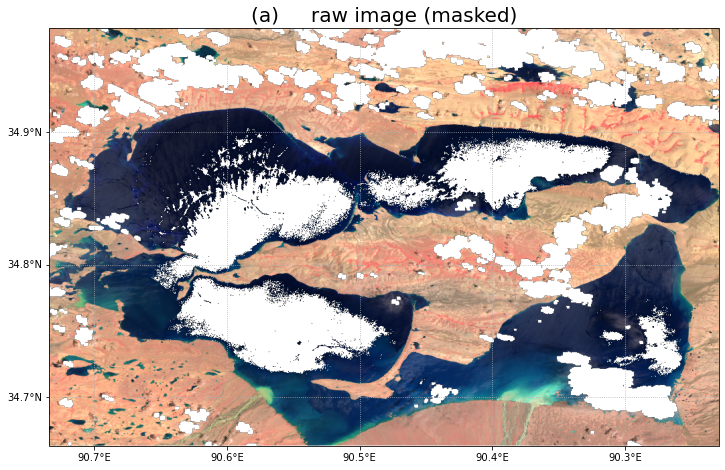

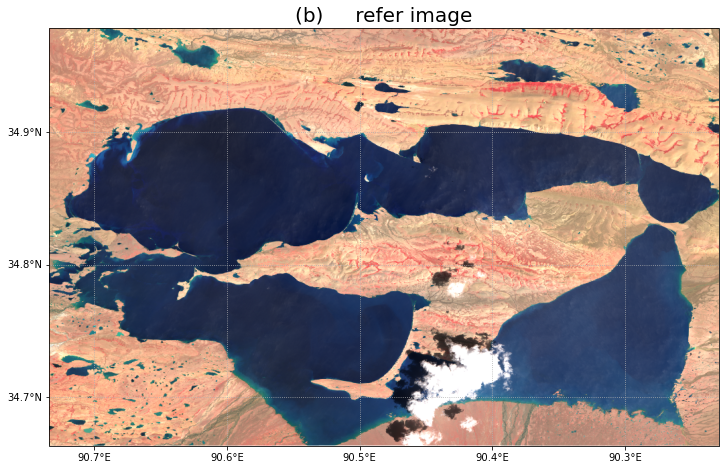

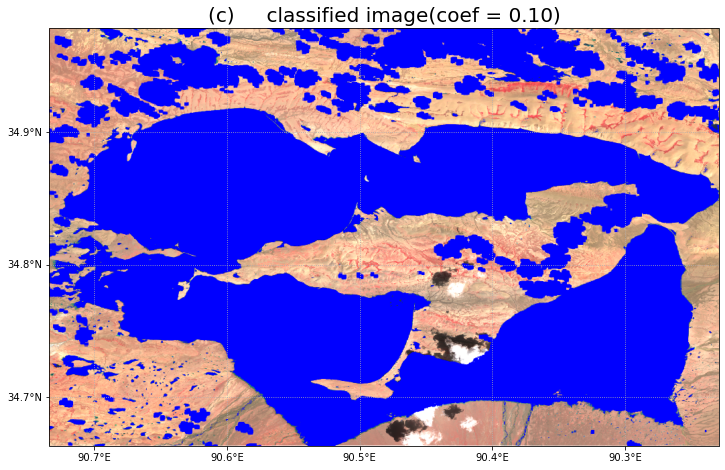

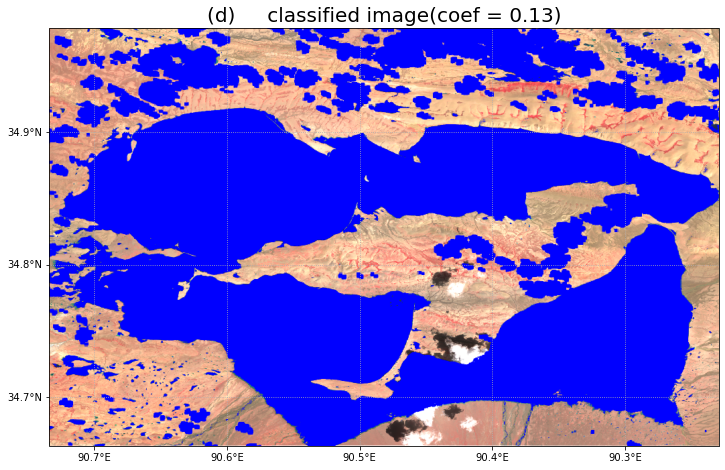

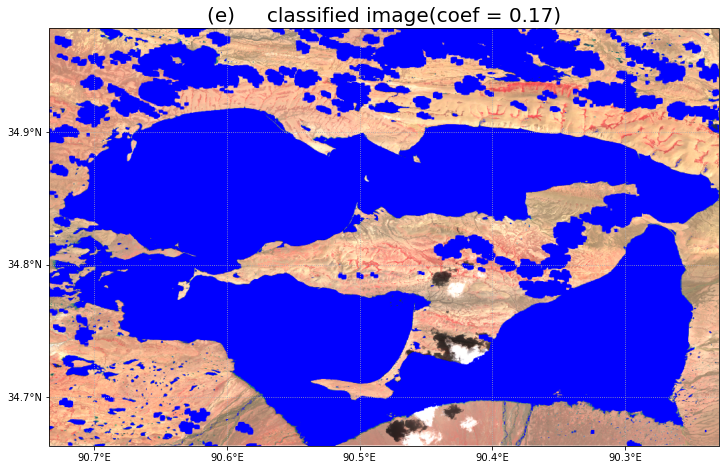

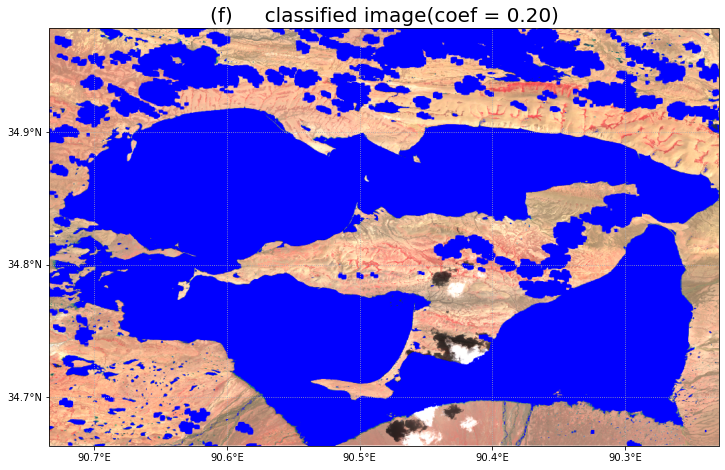

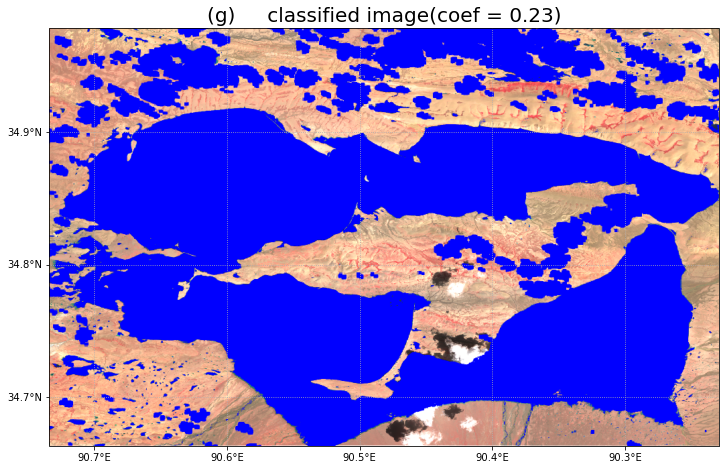

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# item = [['region A','daqing'],['region B','tianjin'],['region C','wuhan'],['region D','prd'],['region E','tibet']]
# item = [['region A','daqing','(a1)'],['region B','tianjin','(b1)'],['region C','wuhan','(c1)'],['region D','prd','(d1)'],['region E','tibet','(e1)']]
item = [['raw image (masked)','(a)'],['refer image','(b)'],['classified image(coef = 0.10)','(c)'],['classified image(coef = 0.13)','(d)'],['classified image(coef = 0.17)','(e)'],['classified image(coef = 0.20)','(f)'],['classified image(coef = 0.23)','(g)']]
for it in item:
    re = [90.2293, 34.6636, 90.7339, 34.9787]
    roi = ee.Geometry.Rectangle(re)
    visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
    if it[1] == '(a)':
        blend = maskSR(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200718')).clip(roi).visualize(**visParams)
    elif it[1] == '(b)':
        blend = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819').clip(roi).visualize(**visParams)
    elif it[1] == '(c)':
        image = ee.Image('users/311605001111/enhance_image_1120_v1').clip(roi).selfMask().visualize(**{'palette':['blue']})
        blend = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819').clip(roi).visualize(**visParams).blend(image)
    elif it[1] == '(d)':
        image = ee.Image('users/311605001111/enhance_image_1120_v2').clip(roi).selfMask().visualize(**{'palette':['blue']})
        blend = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819').clip(roi).visualize(**visParams).blend(image)
    elif it[1] == '(e)':
        image = ee.Image('users/311605001111/enhance_image_1120_v3').clip(roi).selfMask().visualize(**{'palette':['blue']})
        blend = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819').clip(roi).visualize(**visParams).blend(image)
    elif it[1] == '(f)':
        image = ee.Image('users/311605001111/enhance_image_1120_v4').clip(roi).selfMask().visualize(**{'palette':['blue']})
        blend = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819').clip(roi).visualize(**visParams).blend(image)
    elif it[1] == '(g)':
        image = ee.Image('users/311605001111/enhance_image_1120_v5').clip(roi).selfMask().visualize(**{'palette':['blue']})
        blend = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819').clip(roi).visualize(**visParams).blend(image)    
    fig = plt.figure(figsize=(12, 8))    
    ax = cartoee.get_map(blend,region=re)
    cartoee.add_gridlines(ax, interval=[0.1,0.1], linestyle=":")
    ax.set_title(label = it[1] + "     "+ it[0], fontsize=20)

## 整体

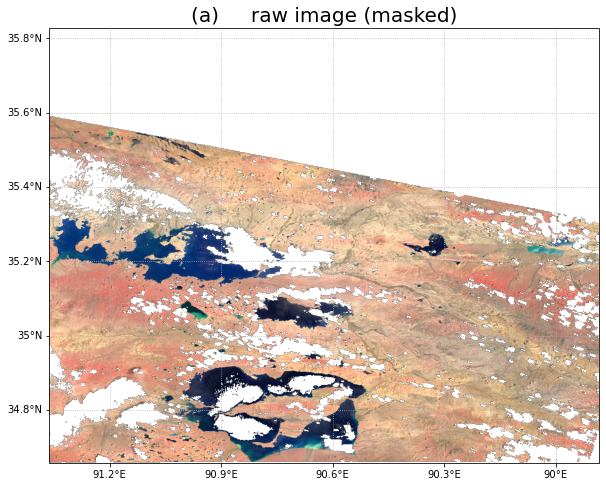

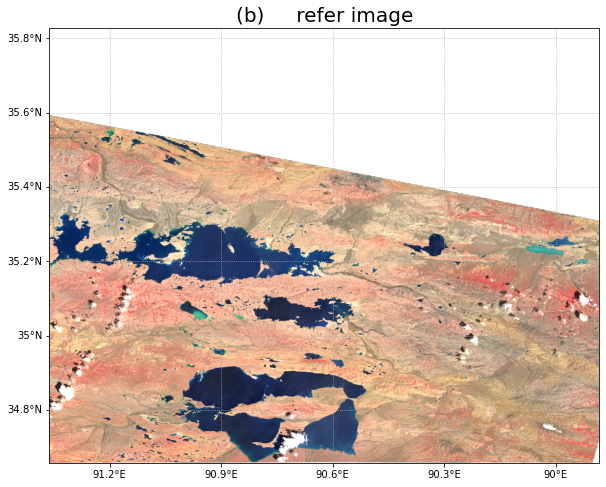

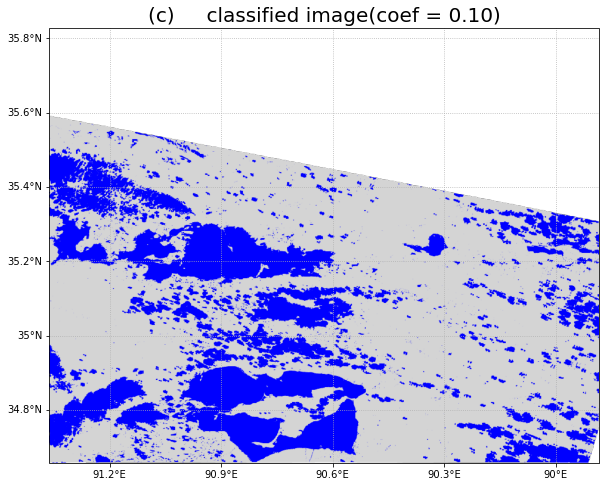

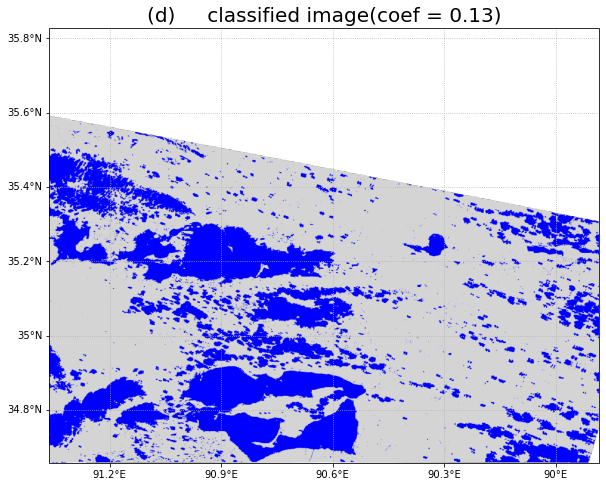

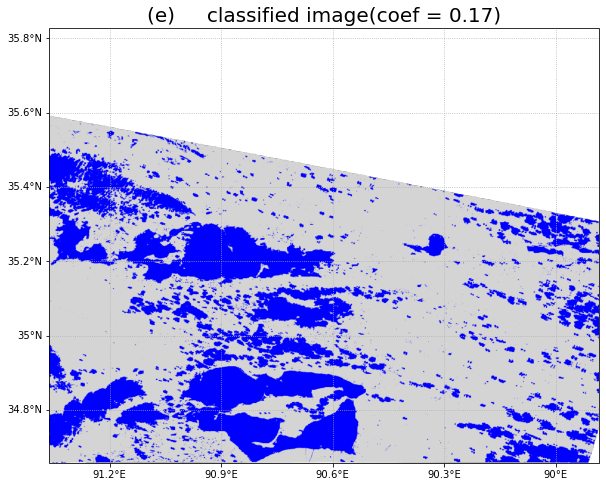

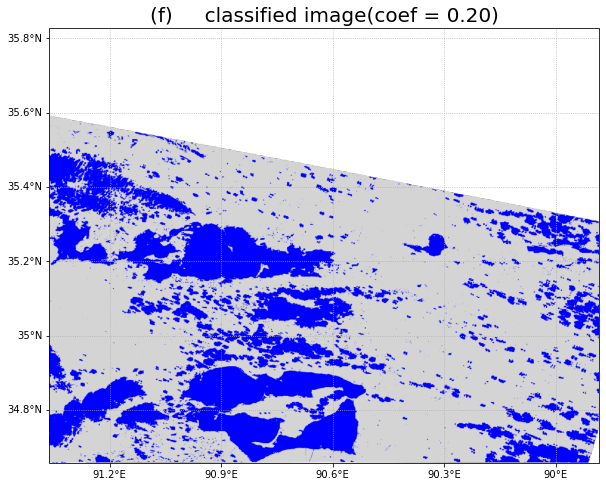

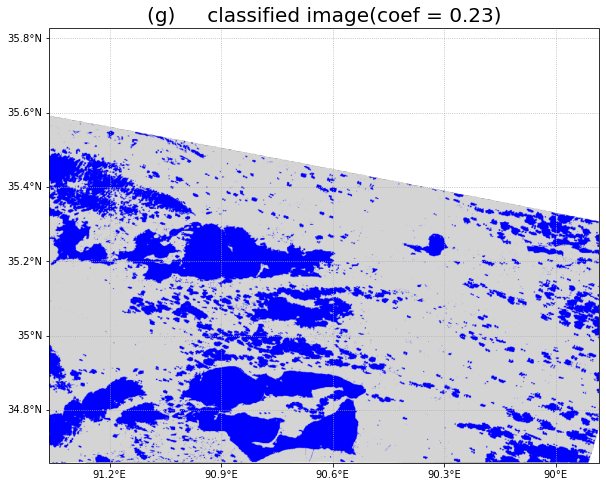

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# item = [['region A','daqing'],['region B','tianjin'],['region C','wuhan'],['region D','prd'],['region E','tibet']]
# item = [['region A','daqing','(a1)'],['region B','tianjin','(b1)'],['region C','wuhan','(c1)'],['region D','prd','(d1)'],['region E','tibet','(e1)']]
item = [['raw image (masked)','(a)'],['refer image','(b)'],['classified image(coef = 0.10)','(c)'],['classified image(coef = 0.13)','(d)'],['classified image(coef = 0.17)','(e)'],['classified image(coef = 0.20)','(f)'],['classified image(coef = 0.23)','(g)']]
for it in item:
    re = [89.8826, 34.6579,91.3626, 35.8279]
    roi = ee.Geometry.Rectangle(re)
    visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
    if it[1] == '(a)':
        blend = maskSR(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200718')).clip(roi).visualize(**visParams)
    elif it[1] == '(b)':
        blend = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819').clip(roi).visualize(**visParams)
    elif it[1] == '(c)':
        blend = ee.Image('users/311605001111/enhance_image_1120_v1').clip(roi).visualize(**{'palette':['D4D4D4','blue'],'min':0,'max':1})
    elif it[1] == '(d)':
        blend = ee.Image('users/311605001111/enhance_image_1120_v2').clip(roi).visualize(**{'palette':['D4D4D4','blue'],'min':0,'max':1})
    elif it[1] == '(e)':
        blend = ee.Image('users/311605001111/enhance_image_1120_v3').clip(roi).visualize(**{'palette':['D4D4D4','blue'],'min':0,'max':1})
    elif it[1] == '(f)':
        blend = ee.Image('users/311605001111/enhance_image_1120_v4').clip(roi).visualize(**{'palette':['D4D4D4','blue'],'min':0,'max':1})
    elif it[1] == '(g)':
        blend = ee.Image('users/311605001111/enhance_image_1120_v5').clip(roi).visualize(**{'palette':['D4D4D4','blue'],'min':0,'max':1})   
    
    fig = plt.figure(figsize=(12, 8))    
    ax = cartoee.get_map(blend,region=re)
    cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
    ax.set_title(label = it[1] + "     "+ it[0], fontsize=20)